Transfer Learning
Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs.

In [3]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models,transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("train on cpu")
else:
    print("train on gpu")

train on cpu


In [6]:
datadir = "data/"
trainDir = os.path.join(datadir, "train/")
testDir = os.path.join( datadir, "test/")
classes = ["man","women"]


In [13]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor()])
trainData = datasets.ImageFolder(trainDir,transform=data_transform)
testData = datasets.ImageFolder(testDir,transform=data_transform)
# print out some data stats
print('Num training images: ', len(trainData))
print('Num test images: ', len(testData))

Num training images:  1590
Num test images:  434


In [16]:
batch = 20
num_workers= 0


# prepare data loaders
train_loader = torch.utils.data.DataLoader(trainData, batch_size=batch, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(testData, batch_size=batch, 
                                          num_workers=num_workers, shuffle=True)

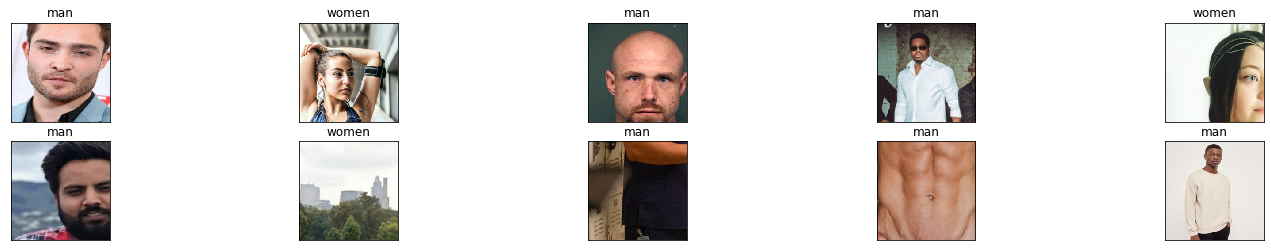

In [21]:
dataiter = iter(train_loader)
images , labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize= (25,4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Define the Model
To define a model for training we'll follow these steps:

Load in a pre-trained VGG16 model
"Freeze" all the parameters, so the net acts as a fixed feature extractor
Remove the last layer
Replace the last layer with a linear classifier of our own
Freezing simply means that the parameters in the pre-trained model will not change during training.

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/shahir/.cache/torch/checkpoints/vgg16-397923af.pth
